Data Source: [nflverse Github](https://github.com/nflverse/nflverse-data?tab=readme-ov-file)

I thought it would be fun to explore the "clutch" ability of QBs, a trait that is often talked about in sports but not in a quantitative manner.

I sourced my data from the nflverse github and used the 2024 play by play (pbp) dataset. In order to simulate clutch enrvironments I preprocessed it to only include plays in the 4th quarter with under 5 minutes remaining, and 7 points or higher score differential.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold

In [5]:
df = pd.read_csv('play_by_play_2024.csv', low_memory = False).query('score_differential <= 7')

In [6]:
qb_data = df.dropna(subset=['passer_player_id']).copy()
qb_data = qb_data[['passer_player_name', 'down', 'ydstogo', 'yardline_100',
                  'game_seconds_remaining', 'epa', 'wpa', 'score_differential', 'qb_epa', 'air_epa']].dropna()

Wanted to first get a baseline on the impact of each of the following features on the expected points added (EPA).

In [7]:
reg_features = ['down', 'ydstogo', 'yardline_100', 'game_seconds_remaining',
               'score_differential']
target = 'epa'

X = qb_data[reg_features]
y = qb_data[target]

reg = LinearRegression().fit(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

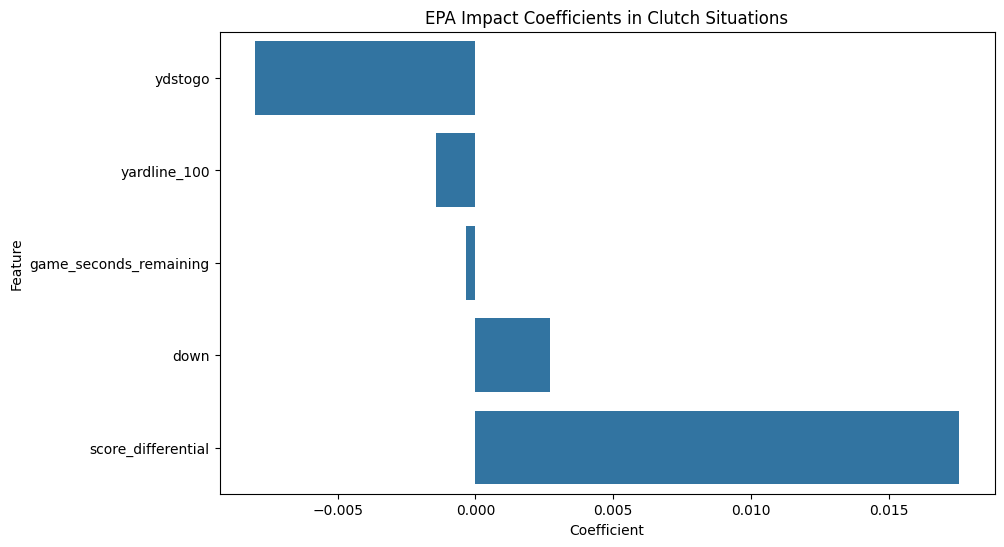

In [8]:
plt.figure(figsize=(10,6))
coef_df = pd.DataFrame({'Feature': reg_features, 'Coefficient': reg.coef_})
sns.barplot(x='Coefficient', y='Feature', data=coef_df.sort_values('Coefficient'))
plt.title('EPA Impact Coefficients in Clutch Situations')
plt.show()

Surprise surprise teams are less likely to score the further away they are, and are more likely to score more when they are down by more!


Now, I wanted to quickly see how much of an impact epa makes to win percentage added (WPA), and identify any correlations to time remaining as that had the lowest contributor to EPA according to the linear regression.

Turns out the less time is on the board the more impactful any EPA is to your chances of winning.

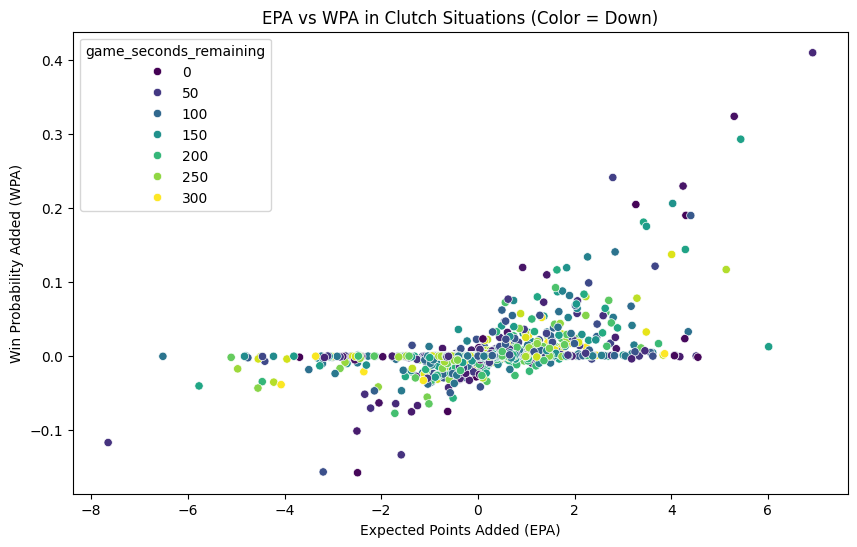

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=qb_data, x='epa', y='wpa', hue='game_seconds_remaining', palette='viridis')
plt.title('EPA vs WPA in Clutch Situations (Color = Down)')
plt.xlabel('Expected Points Added (EPA)')
plt.ylabel('Win Probability Added (WPA)')
plt.show()

In [38]:
# Created my ML model, was overfitting a lot and validation loss would flatline after just 5 epochs,
# so I changed the kernel regularizer to 12, lowered learning rate drastically, and added Dropout.
# experimented a lot with the layers, this configuration seemed to be most effective for this data.

def model(input_shape):
    inputs = Input(shape=(input_shape))
    x = Dense(256, activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(64, activation='relu', kernel_regularizer='l2')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = Dense(32, activation='relu', kernel_regularizer='l2')(x)
    x = Dense(16, activation='relu', kernel_regularizer='l2')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='mse',
                 metrics=['mae'])

    return model
model = model((X_scaled.shape[1],))

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_scaled, y,
    epochs=1000,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 5.5246 - mae: 1.0698 - val_loss: 5.4831 - val_mae: 1.0437
Epoch 2/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2269 - mae: 1.0091 - val_loss: 5.4158 - val_mae: 1.0450
Epoch 3/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0667 - mae: 0.9794 - val_loss: 5.3498 - val_mae: 1.0448
Epoch 4/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9884 - mae: 0.9784 - val_loss: 5.2880 - val_mae: 1.0455
Epoch 5/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2685 - mae: 1.0567 - val_loss: 5.2243 - val_mae: 1.0447
Epoch 6/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1084 - mae: 1.0101 - val_loss: 5.1633 - val_mae: 1.0445
Epoch 7/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8457 - mae: 0.9843 - val_loss: 5.1010 - val_mae: 1.0432
Epoch 8/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9538 - mae: 1.0277 - val_loss: 5.0402 - val_mae: 1.0422
Epoch 9/1000
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - l

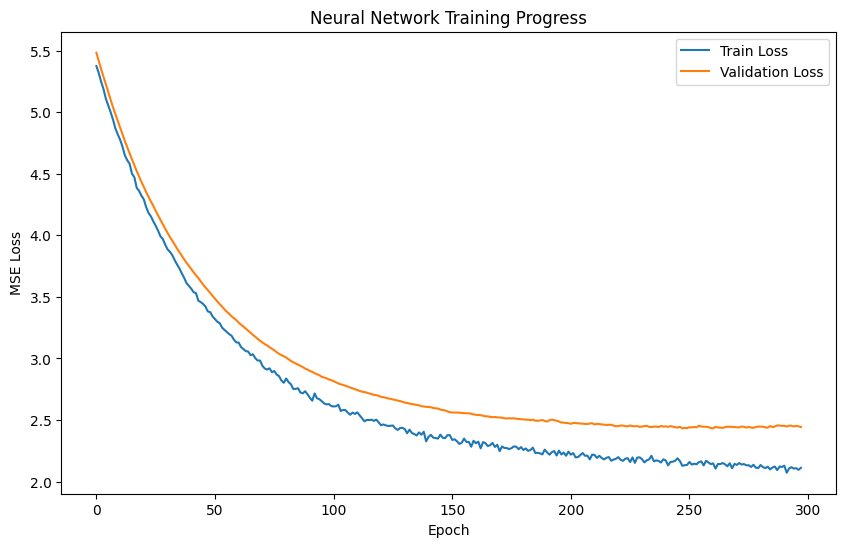

In [40]:
# plotted the training progress, serves as a visual indicator to check if the model
# is overfitting (large gap between train and validation loss)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training Progress')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [41]:
def calculate_ml_clutch_score(df, model, scaler, reg_features):

    # Ml score, included factoring based on time and score differential
    df['clutch_weight'] = (1 / (df['game_seconds_remaining'] + 1)) * (abs(df['score_differential']) + 1)

    ml_metrics = df.groupby('passer_player_name').agg(
        total_epa=('epa', 'sum'),
        avg_wpa=('wpa', 'mean'),
        attempts=('epa', 'count'),
        **{f: (f, 'mean') for f in reg_features}
    ).reset_index()

    X_scaled = scaler.transform(ml_metrics[reg_features])
    ml_metrics['ml_score'] = model.predict(X_scaled).flatten()

    ml_metrics['ml_clutch'] = ml_metrics['total_epa'] * ml_metrics['ml_score']

    return ml_metrics[['passer_player_name', 'ml_clutch']].sort_values('ml_clutch', ascending=False)

In [42]:
def calculate_basic_clutch_score(df):

    #Simple Linear Clutch Score using weighted EPA/WPA
    df['time_weight'] = 1 / (df['game_seconds_remaining'] + 1)
    df['score_weight'] = abs(df['score_differential']) + 1

    basic_metrics = df.groupby('passer_player_name').agg(
        epa=('epa', 'sum'),
        wpa=('wpa', 'mean'),
        time_weight=('time_weight', 'mean'),
        score_weight=('score_weight', 'mean')
    ).reset_index()

    basic_metrics['basic_clutch'] = (
        basic_metrics['epa'] *
        basic_metrics['wpa'] *
        basic_metrics['time_weight'] *
        basic_metrics['score_weight']
    )

    return basic_metrics[['passer_player_name', 'basic_clutch']].sort_values('basic_clutch', ascending=False)

In [43]:
def plot_clutch_comparison(ml_scores, basic_scores):
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    sns.barplot(x='ml_clutch', y='passer_player_name',
                data=ml_scores.head(10))
    plt.title('Top 10 QBs by ML Clutch Score')
    plt.xlabel('')

    plt.subplot(2, 2, 3)
    sns.barplot(x='ml_clutch', y='passer_player_name',
                data=ml_scores.tail(10).sort_values('ml_clutch', ascending=True))
    plt.title('Bottom 10 QBs by ML Clutch Score')

    plt.subplot(2, 2, 2)
    sns.barplot(x='basic_clutch', y='passer_player_name',
                data=basic_scores.head(10))
    plt.title('Top 10 QBs by Basic Clutch Score')
    plt.xlabel('')

    plt.subplot(2, 2, 4)
    sns.barplot(x='basic_clutch', y='passer_player_name',
                data=basic_scores.tail(10).sort_values('basic_clutch', ascending=True))
    plt.title('Bottom 10 QBs by Basic Clutch Score')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)  # Add vertical spacing between rows
    plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


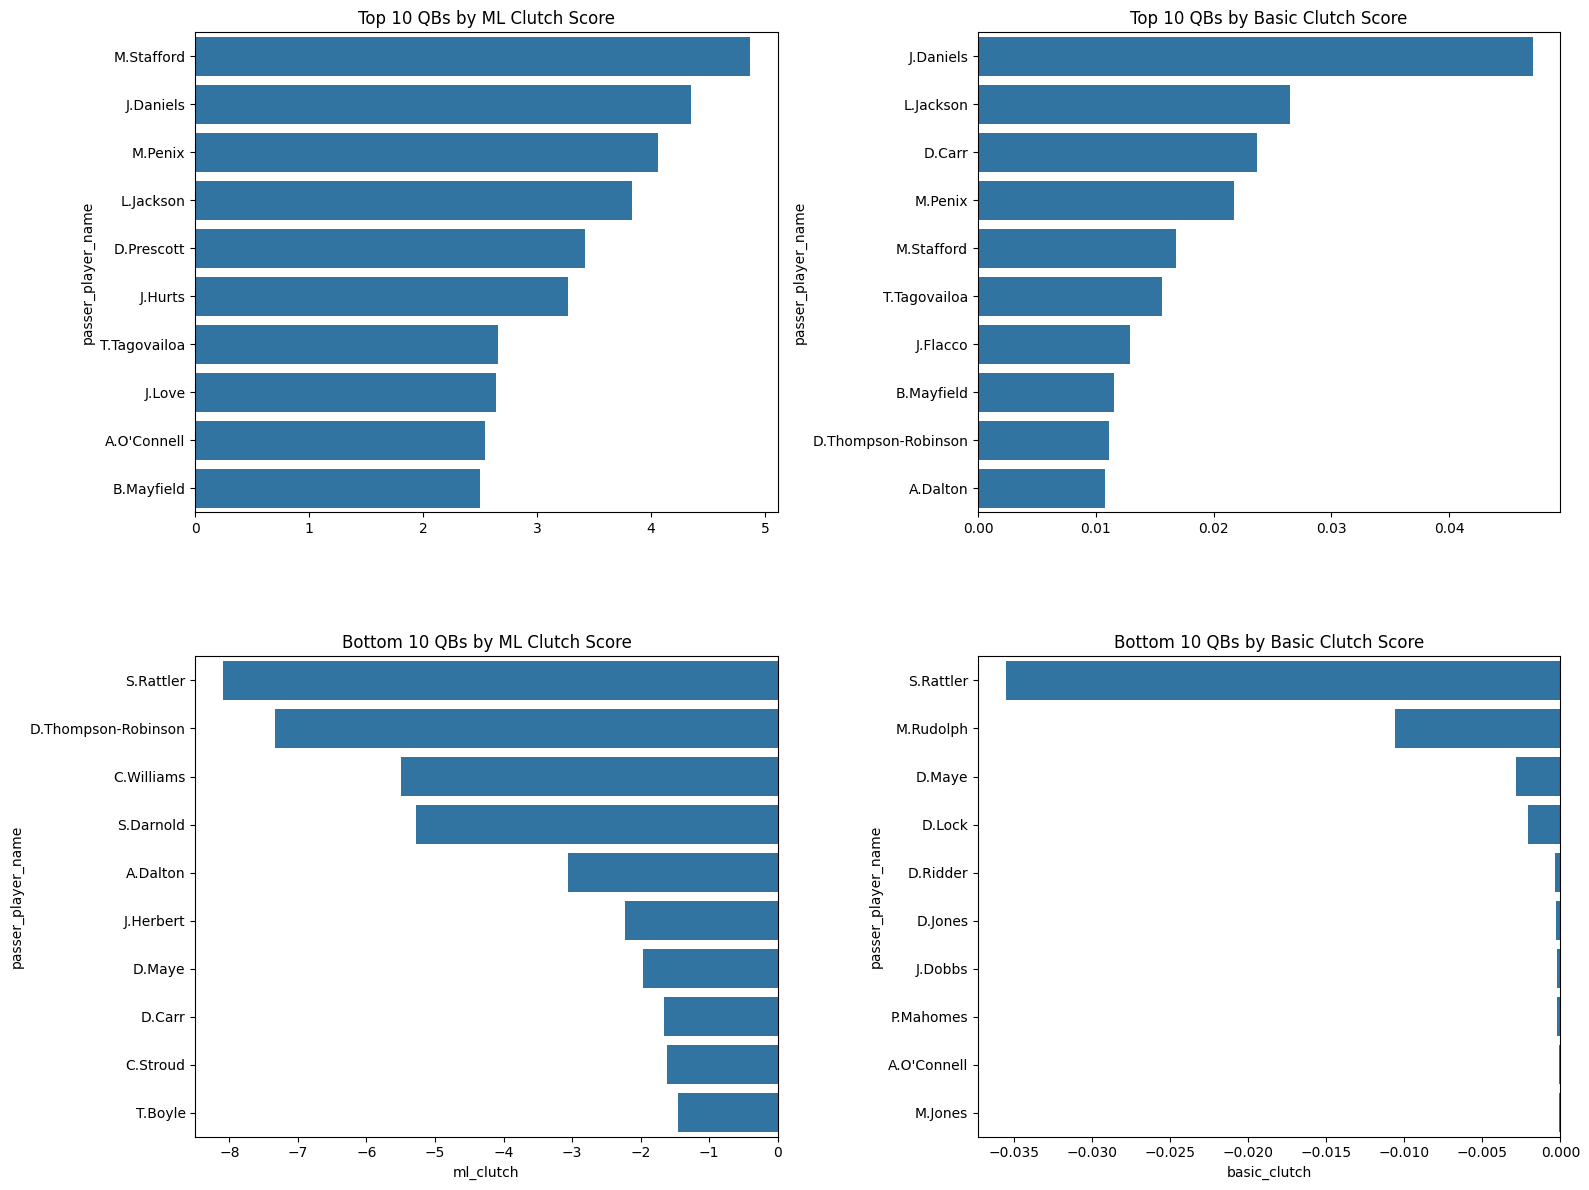

In [44]:
# Plotted the top 10 and bottom 10 QBs predicted by both models.
# Cool to see Jayden Daniels near or at the top of both lists.
# RIP Spencer Rattler

ml_clutch = calculate_ml_clutch_score(df, model, scaler, reg_features)
basic_clutch = calculate_basic_clutch_score(df)

plot_clutch_comparison(ml_clutch, basic_clutch)
